# Ré échantillonage et modélisation sur Alex2: ready_Cloud9am_Cloud3pm.csv (Dartmoor et Adelaide)

## 1. Intro

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree, ensemble, linear_model, svm, neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from joblib import dump, load # pour enregistrer et charger les modèles.

from IPython.display import display_html # pour pouvoir afficher deux df côte à côte.

In [4]:
df = pd.read_csv('ready_Cloud9am_Cloud3pm.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,month,day,LocationNum,WindGustDirNum,WindDir9amNum,WindDir3pmNum,Latitude,Longitude,CodeRegionNum,NonMesNum
0,2009-03-06,8.2,17.6,0.8,3.0,0.0,26.0,0.0,19.0,86.0,...,3,6,27,3.141593,2.915488,3.141593,-37.922544,141.276655,2,6
1,2009-03-07,10.1,19.9,0.8,1.2,5.8,41.0,9.0,24.0,98.0,...,3,7,27,4.319690,2.748894,4.319690,-37.922544,141.276655,2,6
2,2009-03-08,8.8,20.5,0.2,3.6,7.4,41.0,13.0,26.0,68.0,...,3,8,27,5.497787,5.497787,5.890486,-37.922544,141.276655,2,6
3,2009-03-09,8.0,23.9,0.0,4.0,11.2,39.0,17.0,22.0,82.0,...,3,9,27,5.105088,5.497787,5.497787,-37.922544,141.276655,2,6
4,2009-03-10,12.9,27.6,0.0,4.2,4.9,44.0,22.0,24.0,86.0,...,3,10,27,5.890486,5.890486,5.497787,-37.922544,141.276655,2,6


In [6]:
df['RainTomorrow'].value_counts()/df.shape[0]
# 73, 5% de non, 26.4 % de oui
# Il faut rééquilibrer les classes d'arrivée.

RainTomorrow
0    0.735694
1    0.264306
Name: count, dtype: float64

In [7]:
# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date', 'NonMesNum']).copy()
y = df['RainTomorrow'].copy()

In [8]:
# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [9]:
# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<Figure size 500x5000 with 0 Axes>

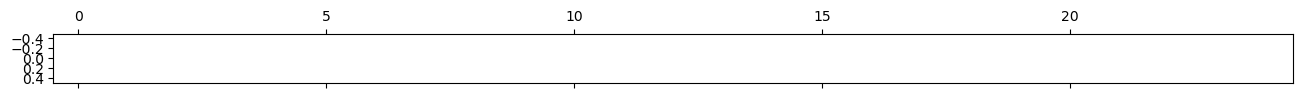

In [10]:
# Feature Selection:
sel = VarianceThreshold(threshold = 0.7)

X_train_var = sel.fit_transform(X_train)
X_test_var = sel.transform(X_test)

mask = sel.get_support()

plt.figure(figsize = (5, 50))
plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
plt.show()

In [11]:
# UnderSample grâce à ClusterCentroids

#Centroids
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)
print('Classes échantillon CC :', dict(pd.Series(y_cc).value_counts()))

C:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


Classes échantillon CC : {0: 1178, 1: 1178}


In [12]:
# Oversample avec SMOTE
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

Classes échantillon SMOTE : {1: 3291, 0: 3291}


## 2. Classification avec logreg

In [11]:
def logreg_report(X_train, y_train, X_test, y_test, title):
    # Cette fonction entraine le modèle logreg sur les données X_train et y_train (qui sont ré-équilibrées en amont)
    # et fait des prédictions sur X_test et y_test (qui elles, ne doivent pas être rééquilibrées)
    # On affiche ensuite le rapport complet: matrice de confusion et classification report
    
    # Instanciation et entrainement du modèle:
    clf = linear_model.LogisticRegression(C = 1.0)
    clf.fit(X_train, y_train)
    
    # Prédiction et évaluation:
    y_test_pred = clf.predict(X_test)
    conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
    class_rep = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, output_dict=True, digits = 2)).T    # création au format df
    
    # Affichage de la matrice de confusion et du rapport de classification:
    df1_styler = conf_mat.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')
    df2_styler = class_rep.style.set_table_attributes("style='display:inline'").set_caption('Classification Report')
    
    #pour afficher au format txt:
    #display_html(print(confusion_matrix(y_test, y_test_pred)) + print(classification_report(y_test, y_test_pred, output_dict=False, digits = 2)), raw=True)
     
    # Pour afficher au format df
    display_html(title + df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
    
# Remarque: j'ai un problème: le df de classification report afffiche beaucoup trop de décimales à mon goût, contrairement au classification report en txt.
# J'ai essayé plusieurs façons d'arrondir le résultat, mais cela ne marche pas... j'aimerai que cela s'affiche avec deux chiffres après la virgules seulement, 
# ce serait plus lisbile.

In [12]:
# Rapport pour logreg avec oversampling smote:
logreg_report(X_sm, y_sm, X_test, y_test, title = 'Rapport pour logreg avec oversampling smote:')


Rapport pour logreg avec oversampling smote:
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 912 
 181 
 
 
 1 
 92 
 305 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.908367 
 0.834401 
 0.869814 
 1093.000000 
 
 
 1 
 0.627572 
 0.768262 
 0.690827 
 397.000000 
 
 
 accuracy 
 0.816779 
 0.816779 
 0.816779 
 0.816779 
 
 
 macro avg 
 0.767969 
 0.801331 
 0.780320 
 1490.000000 
 
 
 weighted avg 
 0.833551 
 0.816779 
 0.822124 
 1490.000000

In [13]:
# Rapport pour logreg avec Undersampling ClusterCentroids:
logreg_report(X_cc, y_cc, X_test, y_test, title = 'Rapport pour logreg avec Undersampling ClusterCentroids')

Rapport pour logreg avec Undersampling ClusterCentroids
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 894 
 199 
 
 
 1 
 86 
 311 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.912245 
 0.817932 
 0.862518 
 1093.000000 
 
 
 1 
 0.609804 
 0.783375 
 0.685777 
 397.000000 
 
 
 accuracy 
 0.808725 
 0.808725 
 0.808725 
 0.808725 
 
 
 macro avg 
 0.761024 
 0.800654 
 0.774148 
 1490.000000 
 
 
 weighted avg 
 0.831662 
 0.808725 
 0.815427 
 1490.000000

Les résultats sont très similaires, il ne semble pas y avoir d'effet du choix de rééchantillonage ici.

## 3. Classement avec SVM:

In [18]:
def svm_report(X_train, y_train, X_test, y_test, title):
    # Cette fonction entraine le modèle svm sur les données X_train et y_train (qui sont ré-équilibrées en amont)
    # et fait des prédictions sur X_test et y_test (qui elles, ne doivent pas être rééquilibrées)
    # On affiche ensuite le rapport complet: matrice de confusion et classification report
    
    # Instanciation et entrainement du modèle:
    clf = svm.SVC(kernel = 'rbf', C=10, gamma = 0.01) # les best params du grid search
    clf.fit(X_train, y_train)
    
    # Prédiction et évaluation:
    y_test_pred = clf.predict(X_test)
    conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
    class_rep = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, output_dict=True, digits = 2)).T    # création au format df
    
    # Affichage de la matrice de confusion et du raport de classification:
    df1_styler = conf_mat.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')
    df2_styler = class_rep.style.set_table_attributes("style='display:inline'").set_caption('Classification Report')
    
    #pour afficher au format txt:
    #display_html(print(confusion_matrix(y_test, y_test_pred)) + print(classification_report(y_test, y_test_pred, output_dict=False, digits = 2)), raw=True)
     
    # Pour afficher au format df
    display_html(title + df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

In [19]:
svm_report(X_sm, y_sm, X_test, y_test, title = 'Rapport pour svm avec oversampling SMOTE:')

Rapport pour svm avec oversampling SMOTE:
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 911 
 182 
 
 
 1 
 99 
 298 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.901980 
 0.833486 
 0.866381 
 1093.000000 
 
 
 1 
 0.620833 
 0.750630 
 0.679590 
 397.000000 
 
 
 accuracy 
 0.811409 
 0.811409 
 0.811409 
 0.811409 
 
 
 macro avg 
 0.761407 
 0.792058 
 0.772985 
 1490.000000 
 
 
 weighted avg 
 0.827071 
 0.811409 
 0.816612 
 1490.000000

In [49]:
svm_report(X_cc, y_cc, X_test, y_test, title = 'Rapport pour svm avec Undersampling ClusterCentroids:')

Rapport pour svm avec Undersampling ClusterCentroids:
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 884 
 209 
 
 
 1 
 87 
 310 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.910402 
 0.808783 
 0.856589 
 1093.000000 
 
 
 1 
 0.597303 
 0.780856 
 0.676856 
 397.000000 
 
 
 accuracy 
 0.801342 
 0.801342 
 0.801342 
 0.801342 
 
 
 macro avg 
 0.753852 
 0.794820 
 0.766723 
 1490.000000 
 
 
 weighted avg 
 0.826979 
 0.801342 
 0.808700 
 1490.000000

#### GridSearch avec SVM

In [44]:
clf = svm.SVC(class_weight = 'balanced') # en sépcifiant 'balanced', on peut faire le grid search sur des données ré-équilibrées (voir (1))

svm_params = {"C" : np.logspace(-2, 2, num = 5), # zone primo conseillée par la doc SVM: -3, 3. Voir aussi ici https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel
             "kernel" :['rbf', 'poly', 'sigmoid'] , 
             "gamma" : np.logspace(-2, 2, num = 5)} # voir ici https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

grid_svm = GridSearchCV(estimator = clf, param_grid = svm_params, cv = 4, scoring = 'f1') 
grid_svm.fit(X_train, y_train) # (1) du coup, pas besoin de rentrer des données équilibrées ici.


GridSearchCV(cv=4, estimator=SVC(class_weight='balanced'),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='f1')

In [ ]:
dump(grid_svm, 'grid_svm.joblib')

In [46]:
grid.best_params_

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}

Ca a dû mettre 30 bonnnes minutes pour le gridsearch, pour rien. Ca ne change presque rien aux résultats de SVM au pif (peut être une amélioration de 0,1% et encore...  
best params avec score accuracy: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
best params avec class weight = balanced et score = f1: ça donne le même en 5 min ici. (en diminuant le span de C et gamma, et en mettant la cv à 4)

Pour l'instant, c'est SVM + undersampling ClustersCentroids qui s'en sort le mieux, mais c'est très peu significatif.

## 4. Classification avec KNN

In [22]:
def knn_report(X_train, y_train, X_test, y_test, title, nn, met):
    # Cette fonction entraine le modèle KNN sur les données X_train et y_train (qui sont ré-équilibrées en amont)
    # et fait des prédictions sur X_test et y_test (qui elles, ne doivent pas être rééquilibrées)
    # On affiche ensuite le rapport complet: matrice de confusion et classification report
    
    # nn est le nombre de voisins dans KNN (n_neighbors)
    # met désigne la métrique à utiliser dans KNN: minkowski, chebyshev, manhattan, ...
    
    # Instanciation et entrainement du modèle:
    clf = neighbors.KNeighborsClassifier(n_neighbors = nn, metric =met)
    clf.fit(X_train, y_train)
    
    # Prédiction et évaluation:
    y_test_pred = clf.predict(X_test)
    conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
    class_rep = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, output_dict=True, digits = 2)).T    # création au format df
    
    # Affichage de la matrice de confusion et du raport de classification:
    df1_styler = conf_mat.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')
    df2_styler = class_rep.style.set_table_attributes("style='display:inline'").set_caption('Classification Report')
    
    #pour afficher au format txt:
    #display_html(print(confusion_matrix(y_test, y_test_pred)) + print(classification_report(y_test, y_test_pred, output_dict=False, digits = 2)), raw=True)
     
    # Pour afficher au format df
    display_html(title + df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

In [59]:
knn_report(X_sm, y_sm, X_test, y_test, title = 'Rapport pour KNN avec oversampling SMOTE:', nn = 25, met = 'manhattan')

Rapport pour KNN avec oversampling SMOTE:
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 846 
 247 
 
 
 1 
 80 
 317 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.913607 
 0.774016 
 0.838039 
 1093.000000 
 
 
 1 
 0.562057 
 0.798489 
 0.659729 
 397.000000 
 
 
 accuracy 
 0.780537 
 0.780537 
 0.780537 
 0.780537 
 
 
 macro avg 
 0.737832 
 0.786253 
 0.748884 
 1490.000000 
 
 
 weighted avg 
 0.819939 
 0.780537 
 0.790529 
 1490.000000

In [73]:
knn_report(X_sm, y_sm, X_test, y_test, title = 'Rapport pour KNN avec Undersampling ClusterCentroids:', nn = 25, met = 'manhattan')

Rapport pour KNN avec Undersampling ClusterCentroids:
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 846 
 247 
 
 
 1 
 80 
 317 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.913607 
 0.774016 
 0.838039 
 1093.000000 
 
 
 1 
 0.562057 
 0.798489 
 0.659729 
 397.000000 
 
 
 accuracy 
 0.780537 
 0.780537 
 0.780537 
 0.780537 
 
 
 macro avg 
 0.737832 
 0.786253 
 0.748884 
 1490.000000 
 
 
 weighted avg 
 0.819939 
 0.780537 
 0.790529 
 1490.000000

C'est pas terrible pour KNN. le meilleur f1 score de la classe positive est sur svm avec undersamblpling CC.

#### GridSearch avec KNN

In [79]:
clf = neighbors.KNeighborsClassifier()

knn_params = {"n_neighbors" : [25, 50, 100], 
             "metric" :['minkowski', 'manhattan', 'chebyshev']
             }

grid_knn = GridSearchCV(estimator = clf, param_grid = knn_params, cv = 4, scoring = 'f1') 
grid_knn.fit(X_cc, y_cc)


GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan', 'chebyshev'],
                         'n_neighbors': [25, 50, 100]},
             scoring='f1')

In [80]:
grid_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 25}

{'metric': 'manhattan', 'n_neighbors': 25}  
Ca augmente d'un demi-pourcent le score que j'avais avec manhattan et nn = 15.

In [ ]:
dump(grid_knn, 'grid_knn.joblib')

## 5. Classification avec RandomForest

In [23]:
def rdf_report(X_train, y_train, X_test, y_test, title):
    
    # Instanciation et entrainement du modèle:
    clf = ensemble.RandomForestClassifier(n_estimators = 300, criterion = 'log_loss')
    clf.fit(X_train, y_train)
    
    # Prédiction et évaluation:
    y_test_pred = clf.predict(X_test)
    conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
    class_rep = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, output_dict=True, digits = 2)).T    # création au format df
    
    # Affichage de la matrice de confusion et du raport de classification:
    df1_styler = conf_mat.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')
    df2_styler = class_rep.style.set_table_attributes("style='display:inline'").set_caption('Classification Report')
    
    #pour afficher au format txt:
    #display_html(print(confusion_matrix(y_test, y_test_pred)) + print(classification_report(y_test, y_test_pred, output_dict=False, digits = 2)), raw=True)
     
    # Pour afficher au format df
    display_html(title + df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

In [91]:
rdf_report(X_sm, y_sm, X_test, y_test, "RandomForest avec SMOTE")

RandomForest avec SMOTE
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 960 
 133 
 
 
 1 
 119 
 278 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.889713 
 0.878317 
 0.883978 
 1093.000000 
 
 
 1 
 0.676399 
 0.700252 
 0.688119 
 397.000000 
 
 
 accuracy 
 0.830872 
 0.830872 
 0.830872 
 0.830872 
 
 
 macro avg 
 0.783056 
 0.789284 
 0.786048 
 1490.000000 
 
 
 weighted avg 
 0.832877 
 0.830872 
 0.831793 
 1490.000000

In [92]:
rdf_report(X_cc, y_cc, X_test, y_test, "RandomForest avec ClusterCentroids")

RandomForest avec ClusterCentroids
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 858 
 235 
 
 
 1 
 71 
 326 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.923574 
 0.784995 
 0.848665 
 1093.000000 
 
 
 1 
 0.581105 
 0.821159 
 0.680585 
 397.000000 
 
 
 accuracy 
 0.794631 
 0.794631 
 0.794631 
 0.794631 
 
 
 macro avg 
 0.752339 
 0.803077 
 0.764625 
 1490.000000 
 
 
 weighted avg 
 0.832325 
 0.794631 
 0.803881 
 1490.000000

In [88]:
clf = ensemble.RandomForestClassifier(class_weight = 'balanced')

rdf_params = {"n_estimators" : [200, 300, 500], 
             "criterion" :['gini', 'entropy', 'log_loss']
             }

grid_rdf = GridSearchCV(estimator = clf, param_grid = rdf_params, cv = 4, scoring = 'f1') 
grid_rdf.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [200, 300, 500]},
             scoring='f1')

In [89]:
grid_rdf.best_params_

{'criterion': 'log_loss', 'n_estimators': 300}

In [ ]:
dump(grid_rdf, 'grid_rdf.joblib')

In [105]:
rdf = ensemble.RandomForestClassifier(n_estimators = 300, criterion = 'log_loss')
rdf.fit(X_sm, y_sm)
#tree.plot_tree(rdf)

RandomForestClassifier(criterion='log_loss', n_estimators=300)

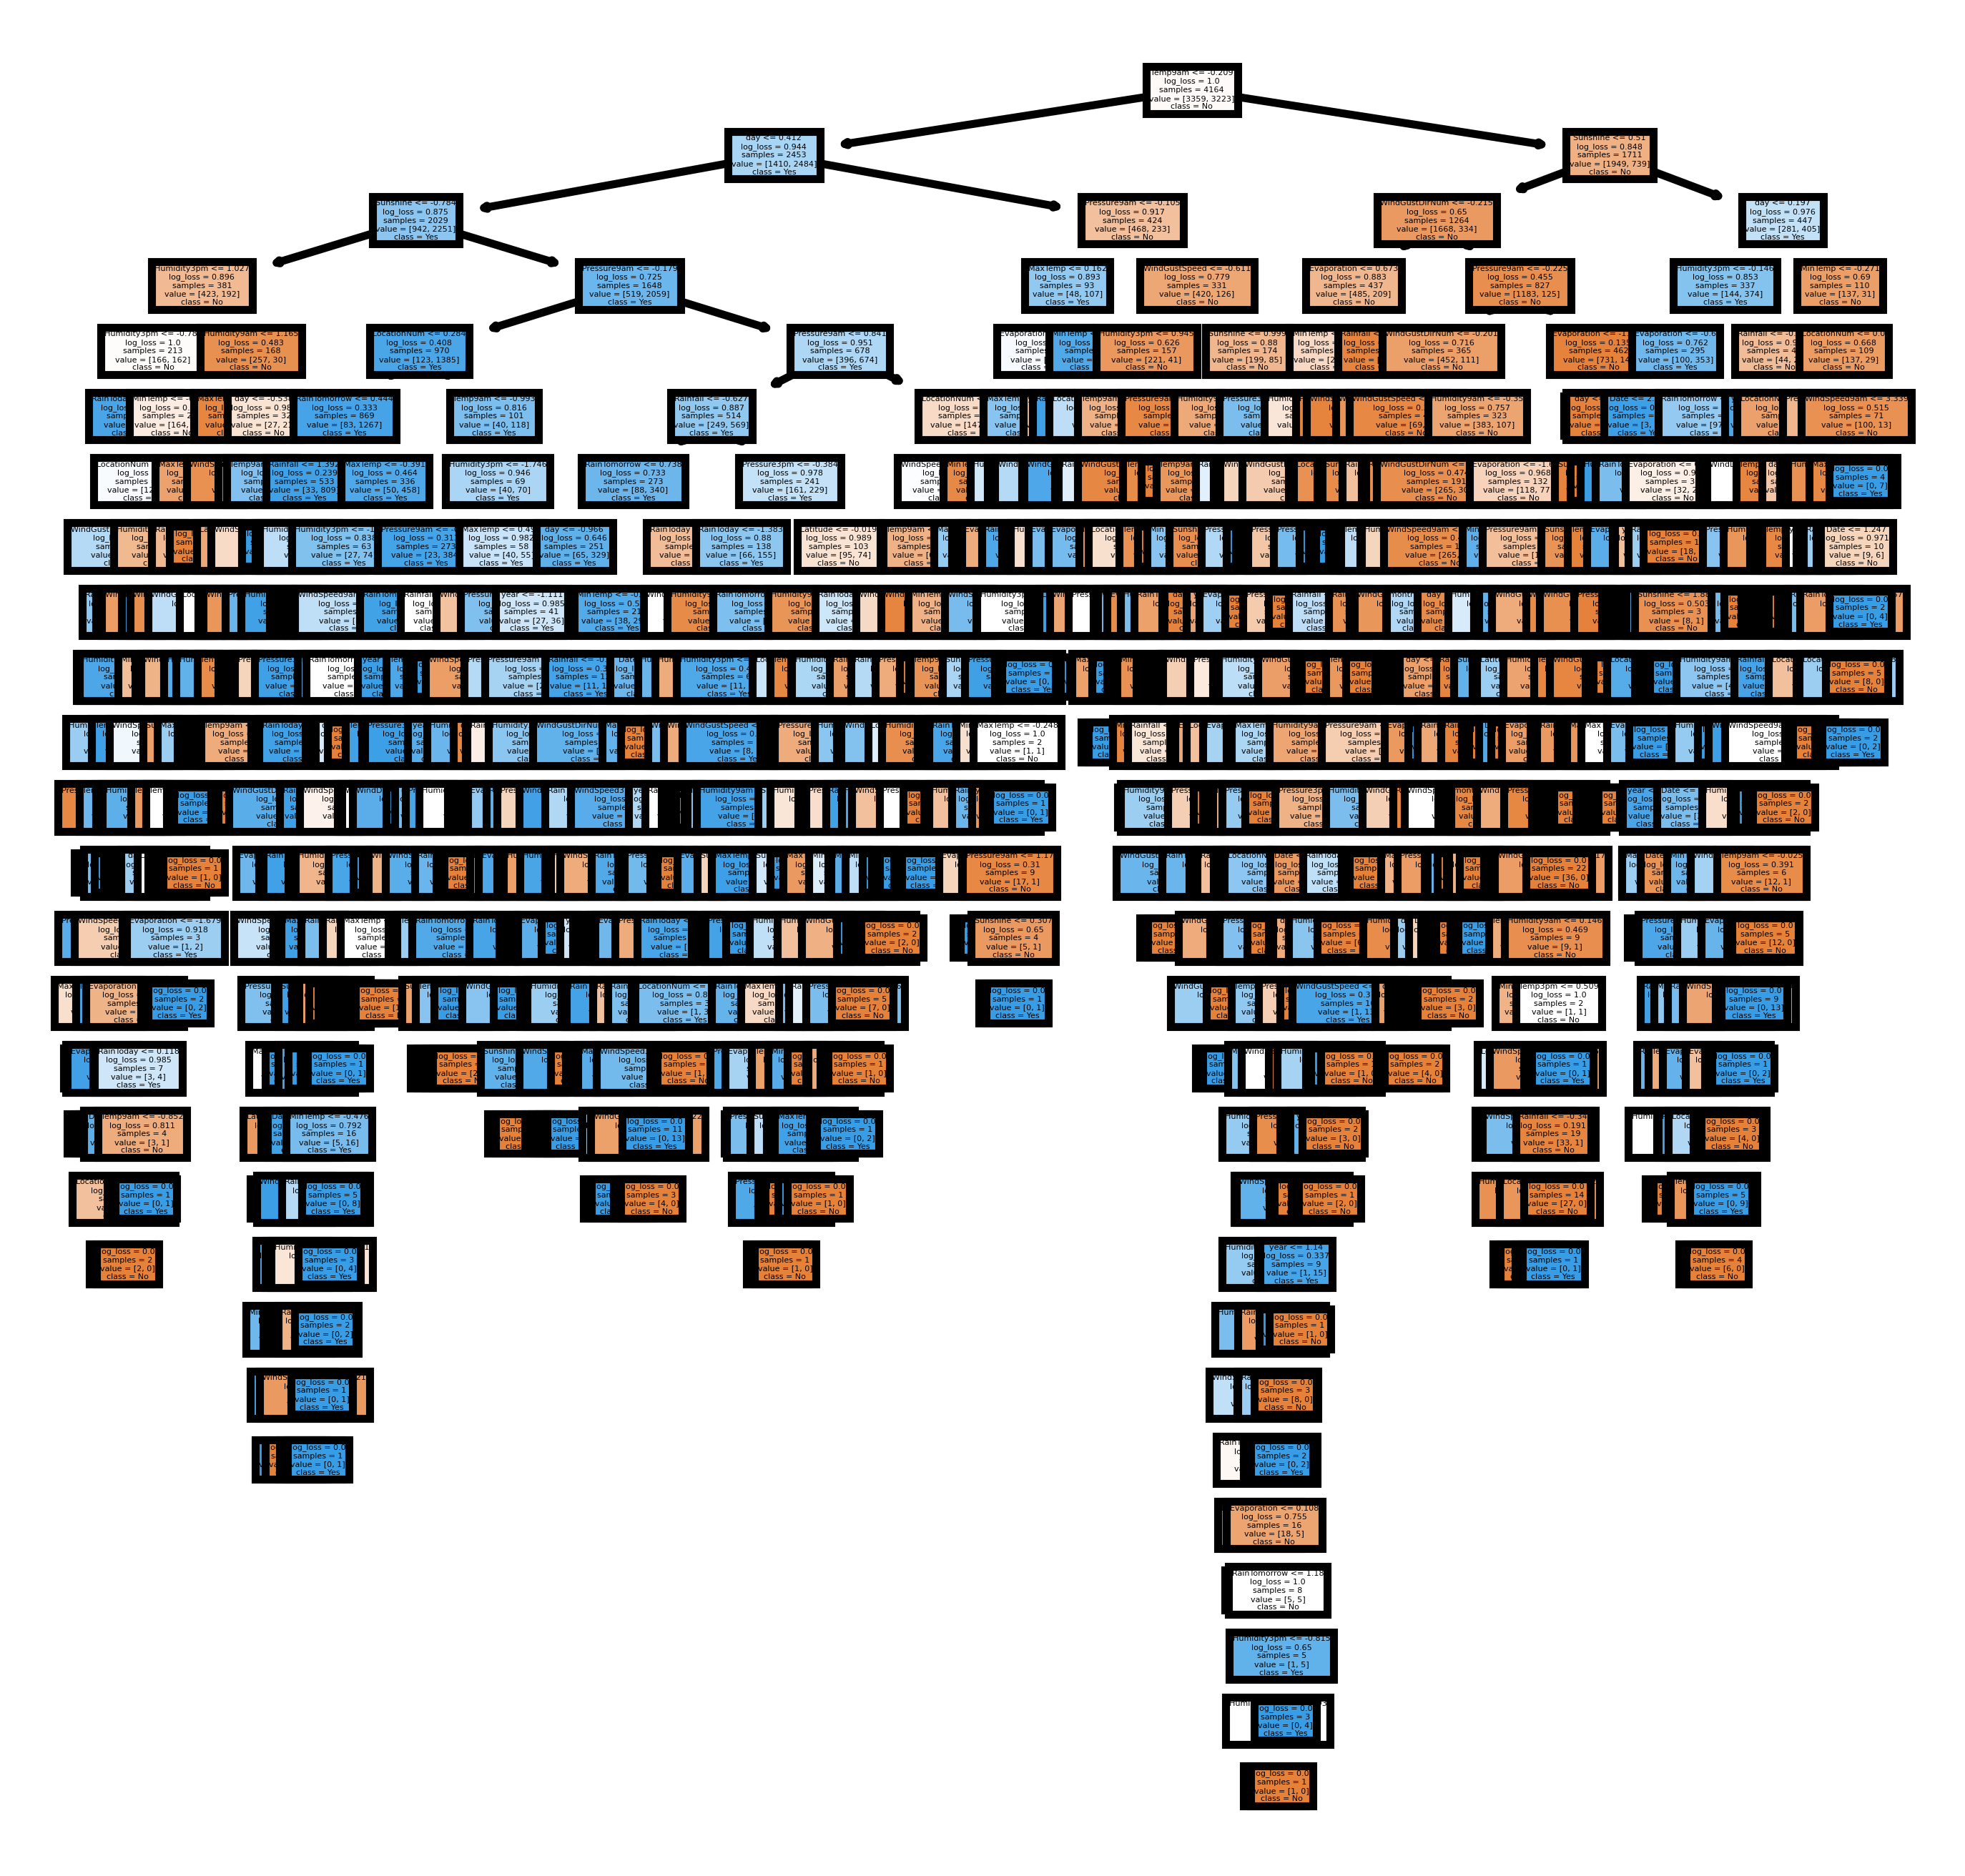

In [106]:
fn=df.columns
cn= ['No', 'Yes']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rdf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True)
fig.savefig('rf_individualtree.png')

On arrive à 68 de f1/1.

## 6. Bilan de la journée:

Meilleur classifieur: RandomForest, n estimators = 300, criterion = 'log_loss' avec sur SMOTE: 83% en accuracy et 78, 6 en f1 macro avg

In [107]:
y_pred = rdf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])
cm

Classes prédites,0,1
Classes réelles,,
0,963,130
1,116,281


In [109]:
y_probas = rdf.predict_proba(X_test)

In [112]:
import scikitplot as skplt

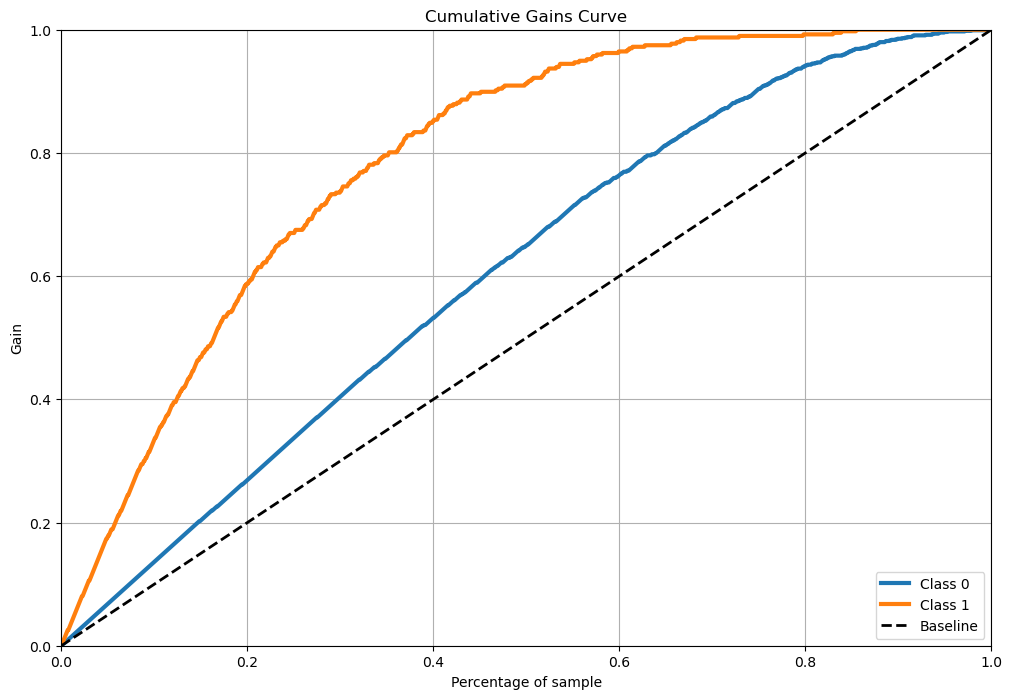

In [113]:
skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(12,8))
plt.show()

In [114]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


fpr, tpr, seuils = roc_curve (y_test, y_probas[:,1], pos_label = 1) 
# pas précisé mais tpr = true positive rate
# et fpr = false positive rate

roc_auc = auc(x = fpr, y = tpr)

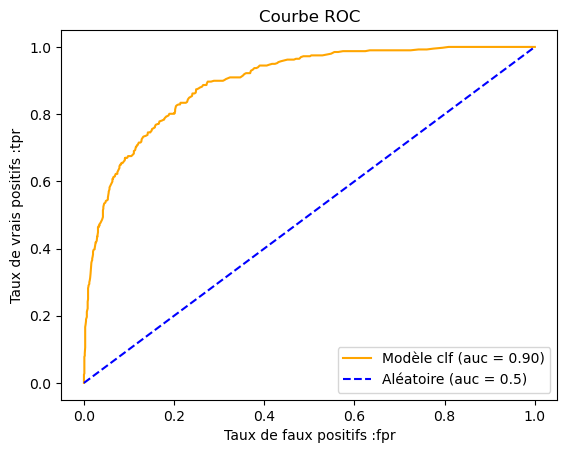

In [115]:
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()
plt.show()


## 7. Feature Selection

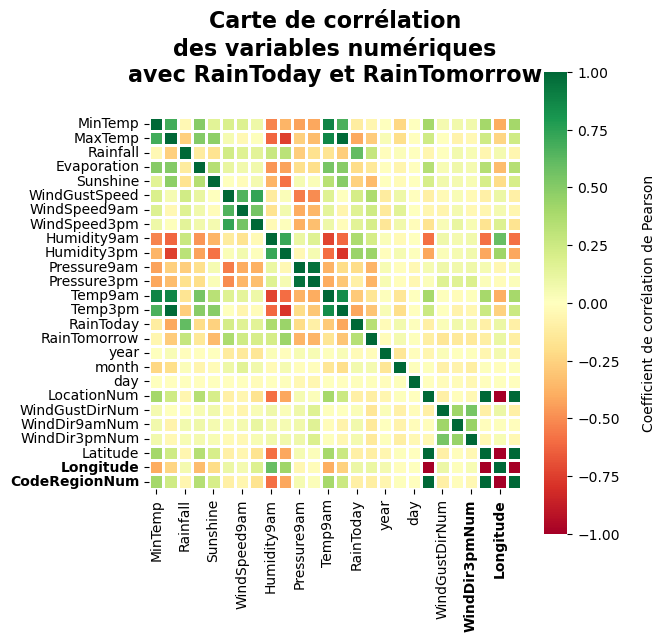

In [7]:
df.drop(columns = ['Date', 'NonMesNum'], inplace = True)
## Initialisation de la toile
fig, ax = plt.subplots(figsize = (6, 6))

## Traçage
sns.heatmap(df.corr(), 
            square = True, 
            linewidth = 1, 
            vmin = -1, 
            vmax = 1, 
            cmap = "RdYlGn", 
            cbar_kws = {"label": "\nCoefficient de corrélation de Pearson"})

## Mise en forme
plt.title("Carte de corrélation\ndes variables numériques\navec RainToday et RainTomorrow\n", 
          fontweight = "bold", 
          fontsize = 16)

# Mise en évidence de la variable cible `RainTomorrow`
ax.get_xticklabels()[-1].set_weight("bold")
ax.get_xticklabels()[-2].set_weight("bold")
ax.get_yticklabels()[-1].set_weight("bold")
ax.get_yticklabels()[-2].set_weight("bold")

plt.show()

In [12]:
df.corr()['RainTomorrow'].sort_values(ascending = False)

RainTomorrow      1.000000
Humidity3pm       0.429374
WindGustSpeed     0.372941
RainToday         0.330715
Rainfall          0.277694
WindSpeed9am      0.239645
Humidity9am       0.211461
WindSpeed3pm      0.203560
Longitude         0.109006
month             0.059515
day               0.014519
year             -0.018544
MinTemp          -0.057863
LocationNum      -0.109006
CodeRegionNum    -0.109006
Latitude         -0.109006
WindDir9amNum    -0.133825
WindDir3pmNum    -0.139718
Evaporation      -0.141134
WindGustDirNum   -0.153325
Temp9am          -0.157716
MaxTemp          -0.277588
Temp3pm          -0.310387
Sunshine         -0.346399
Pressure3pm      -0.369168
Pressure9am      -0.374844
Name: RainTomorrow, dtype: float64

In [13]:
columns_to_drop = ['Longitude', 'month', 'day', 'year', 'MinTemp', 'LocationNum', 'CodeRegionNum', 'Latitude'] # drop sur tout ce qui corrèle à moins de 0.11 en valeur absolue.
df_sel = df.drop(columns = columns_to_drop).copy()

In [15]:
# Séparation data / target:
X_sel = df_sel.drop(columns = 'RainTomorrow').copy()
y_sel = df_sel['RainTomorrow']

# Séparation du jeu d'entrainement et du jeu de test:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size = 0.25, random_state = 123)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train_sel = scaler.fit_transform(X_train_sel)
X_test_sel = scaler.transform(X_test_sel)

# UnderSample grâce à ClusterCentroids
cc_sel = ClusterCentroids()
X_cc_sel, y_cc_sel = cc_sel.fit_resample(X_train_sel, y_train_sel)
print('Classes échantillon CC :', dict(pd.Series(y_cc_sel).value_counts()))

# Oversample avec SMOTE
smote = SMOTE()
X_sm_sel, y_sm_sel = smote.fit_resample(X_train_sel, y_train_sel)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm_sel).value_counts()))

C:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


Classes échantillon CC : {0: 1178, 1: 1178}
Classes échantillon SMOTE : {1: 3291, 0: 3291}


In [18]:
clf = ensemble.RandomForestClassifier(class_weight = 'balanced')

rdf_params = {"n_estimators" : [5, 20, 50, 100, 200, 300, 500], 
             "criterion" :['gini', 'entropy', 'log_loss']
             }

grid_rdf_sel = GridSearchCV(estimator = clf, param_grid = rdf_params, cv = 4, scoring = 'f1') 
grid_rdf_sel.fit(X_train_sel, y_train_sel)

GridSearchCV(cv=4, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [5, 20, 50, 100, 200, 300, 500]},
             scoring='f1')

In [20]:
grid_rdf_sel.best_params_
# C'est le même critère mais avec 200 estimateurs au lieu de 300 dans le cas du tableau complet.

{'criterion': 'log_loss', 'n_estimators': 200}

In [21]:
dump(grid_rdf_sel, 'grid_rdf_sel.joblib')

['grid_rdf_sel.joblib']

In [27]:
def rdf_report(X_train, y_train, X_test, y_test, title):
    
    # Instanciation et entrainement du modèle:
    clf = ensemble.RandomForestClassifier(n_estimators = 200, criterion = 'log_loss')
    clf.fit(X_train, y_train)
    
    # Prédiction et évaluation:
    y_test_pred = clf.predict(X_test)
    conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
    class_rep = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, output_dict=True, digits = 2)).T    # création au format df
    
    # Affichage de la matrice de confusion et du raport de classification:
    df1_styler = conf_mat.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')
    df2_styler = class_rep.style.set_table_attributes("style='display:inline'").set_caption('Classification Report')
    
    #pour afficher au format txt:
    #display_html(print(confusion_matrix(y_test, y_test_pred)) + print(classification_report(y_test, y_test_pred, output_dict=False, digits = 2)), raw=True)
     
    # Pour afficher au format df
    display_html(title + df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

In [28]:
rdf_report(X_sm_sel, y_sm_sel, X_test_sel, y_test_sel, "RandomForest avec SMOTE avec Features selection")

RandomForest avec SMOTE avec Features selection
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 955 
 138 
 
 
 1 
 113 
 284 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.894195 
 0.873742 
 0.883850 
 1093.000000 
 
 
 1 
 0.672986 
 0.715365 
 0.693529 
 397.000000 
 
 
 accuracy 
 0.831544 
 0.831544 
 0.831544 
 0.831544 
 
 
 macro avg 
 0.783590 
 0.794554 
 0.788689 
 1490.000000 
 
 
 weighted avg 
 0.835255 
 0.831544 
 0.833140 
 1490.000000

In [29]:
rdf_report(X_cc_sel, y_cc_sel, X_test_sel, y_test_sel, "RandomForest avec ClusterCentroids avec Features selection")

RandomForest avec ClusterCentroids avec Features selection
 
 Confusion Matrix 
 
 
 Classes prédites 
 0 
 1 
 
 
 Classes réelles 
   
   
 
 
 
 
 0 
 835 
 258 
 
 
 1 
 72 
 325 
 
 
 

 
 Classification Report 
 
 
   
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 0 
 0.920617 
 0.763952 
 0.835000 
 1093.000000 
 
 
 1 
 0.557461 
 0.818640 
 0.663265 
 397.000000 
 
 
 accuracy 
 0.778523 
 0.778523 
 0.778523 
 0.778523 
 
 
 macro avg 
 0.739039 
 0.791296 
 0.749133 
 1490.000000 
 
 
 weighted avg 
 0.823857 
 0.778523 
 0.789243 
 1490.000000

Bilan: C'est toujours RdF/SMOTE qui a le meilleur f1-score en weighted average. Le score ici obtenu en enlevant des variables peu correllées n'est pas différent de celui obtenu avec le tableau complet:  
tableau complet: 83, 1%  
tableau sélectionné: 83, 3%  

In [33]:
rdf_sel = ensemble.RandomForestClassifier(n_estimators = 200, criterion = 'log_loss')
rdf_sel.fit(X_sm_sel, y_sm_sel)
#tree.plot_tree(rdf)

RandomForestClassifier(criterion='log_loss', n_estimators=200)

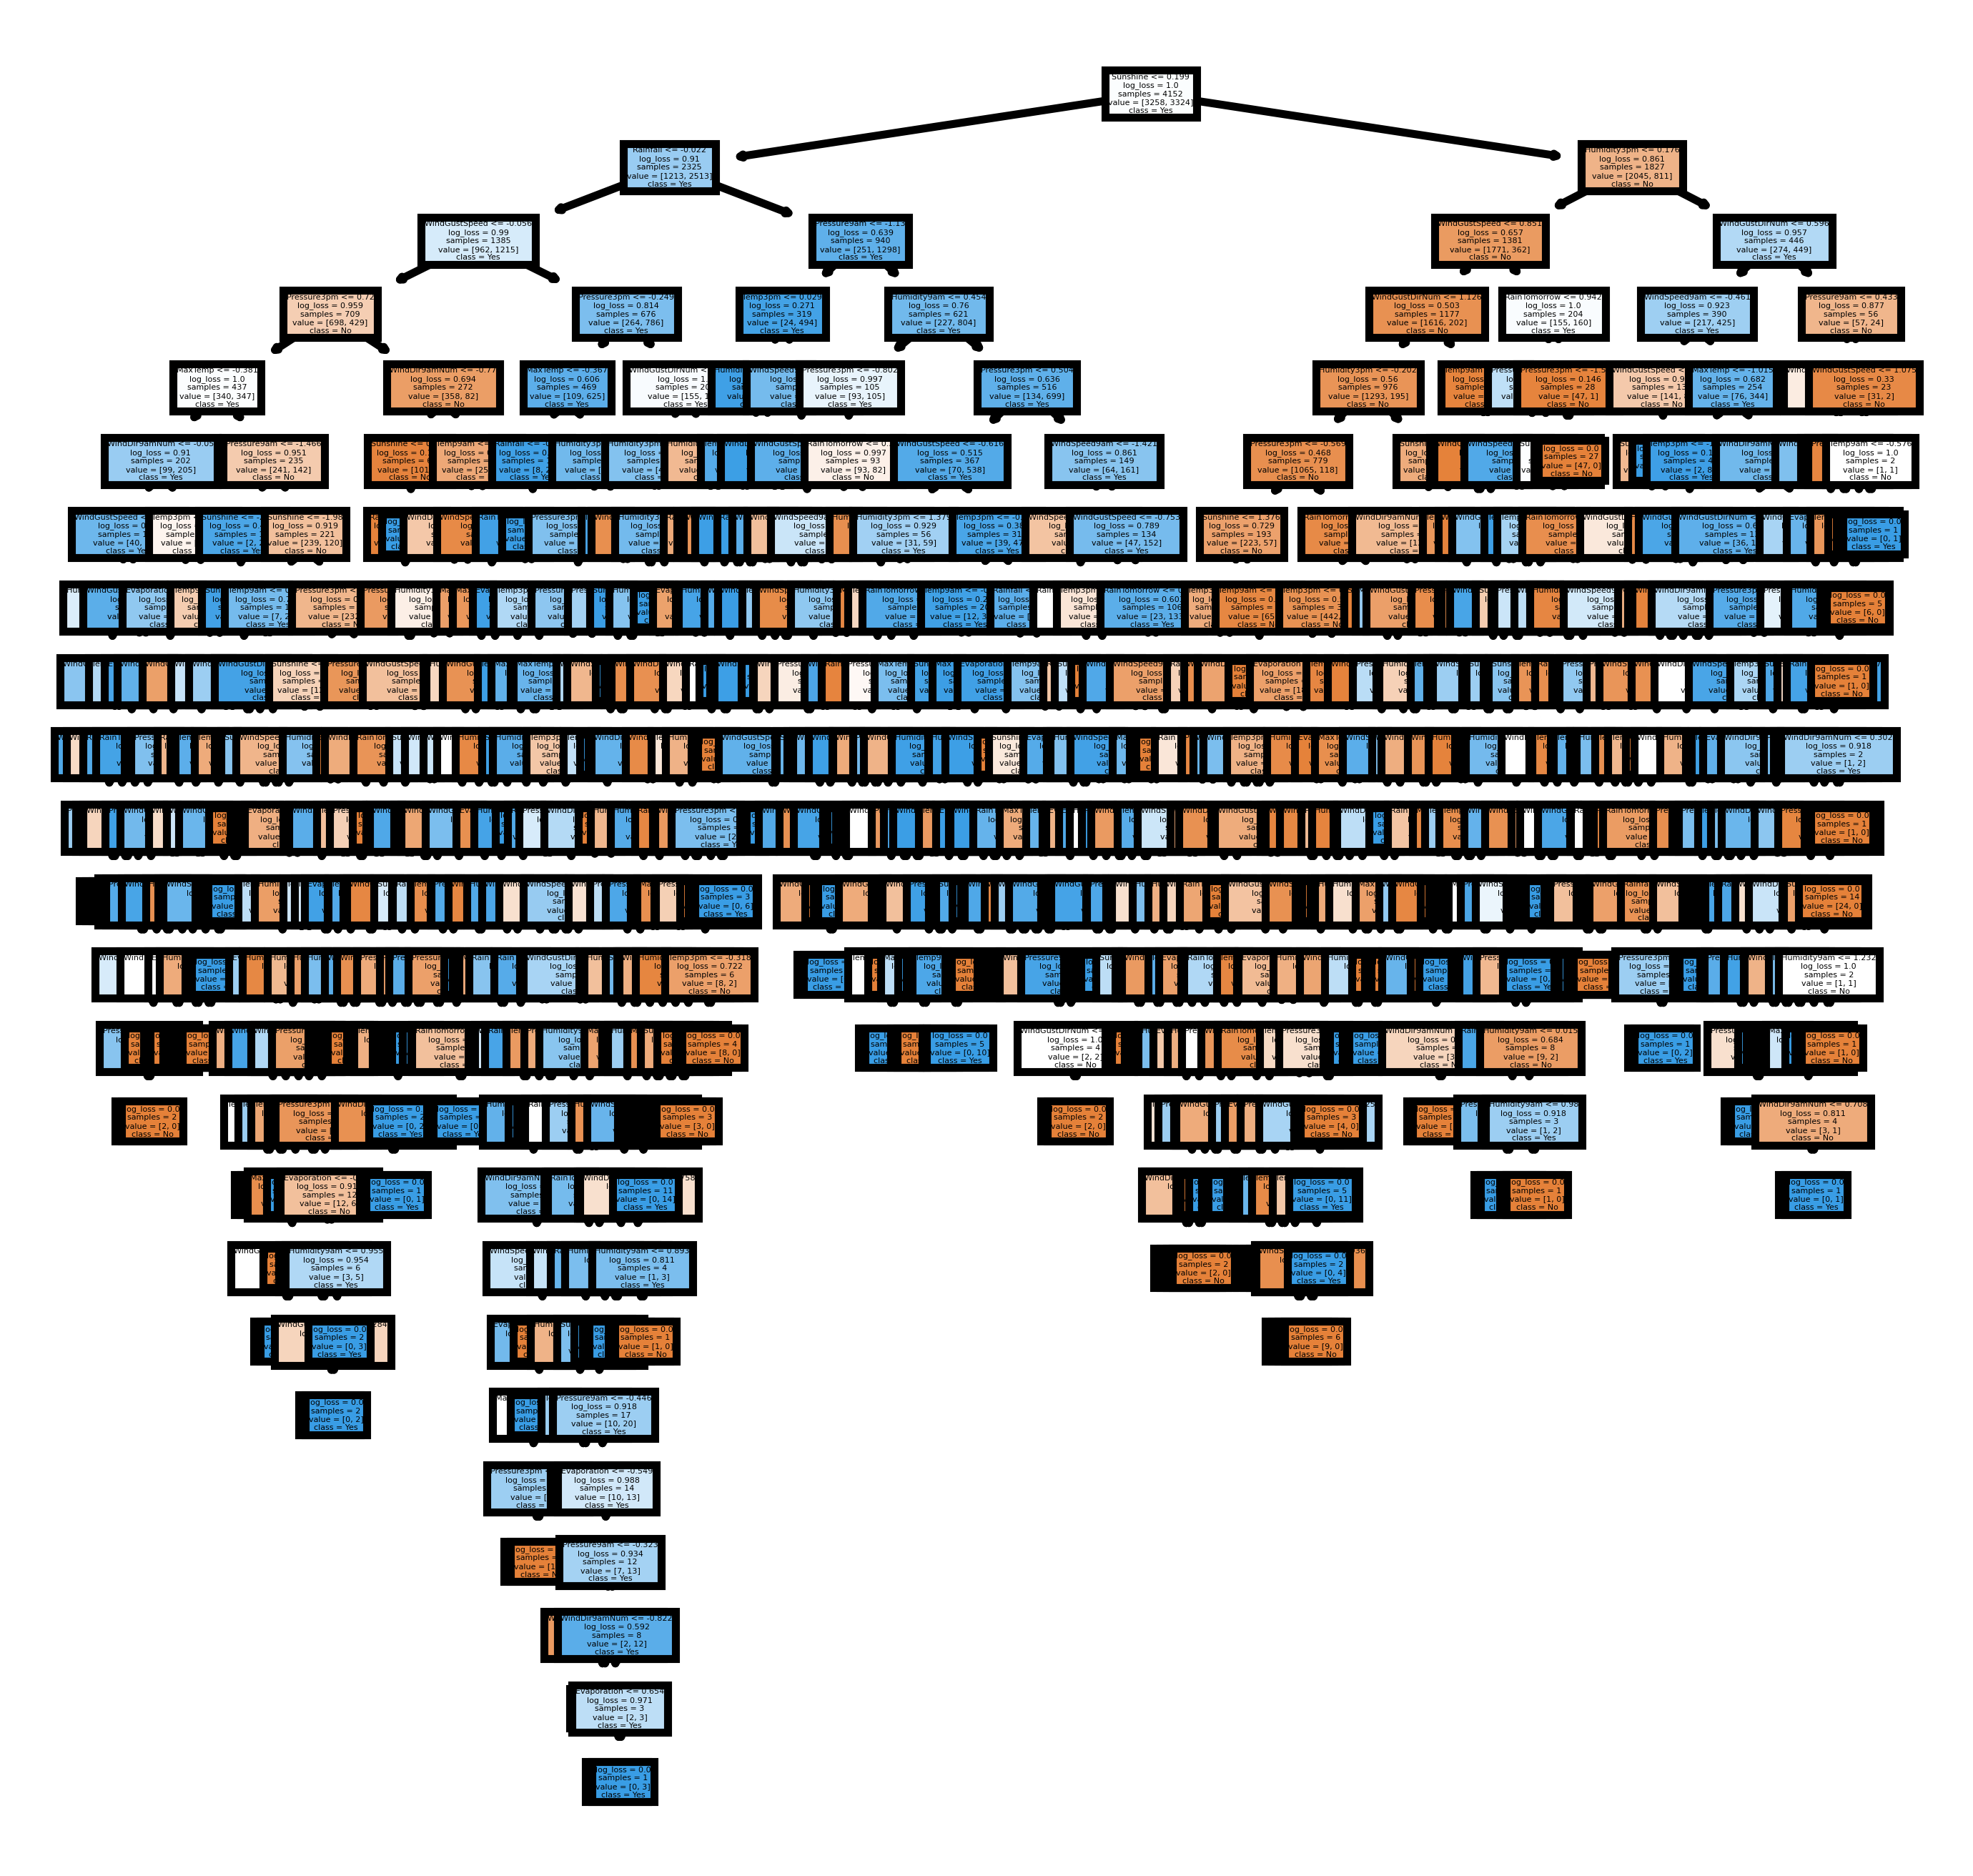

In [35]:
fn_sel=df_sel.columns
cn_sel= ['No', 'Yes']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rdf_sel.estimators_[0],
               feature_names = fn_sel, 
               class_names=cn_sel,
               filled = True)
plt.show()
# fig.savefig('rf_individualtree.png')

Que faire d'autre? Un Xgboost?